<a href="https://colab.research.google.com/github/vicentcamison/idal_ia3/blob/main/2%20Aprendizaje%20profundo%20(I)/Sesion%203/Titanic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [180]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input, Lambda, Dropout
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
tf.random.set_seed(42)

In [74]:
data_train = pd.read_csv('https://raw.githubusercontent.com/vicentcamison/idal_ia3/main/2%20Aprendizaje%20profundo%20(I)/Sesion%203/titanic_train.csv')
data_test = pd.read_csv('https://raw.githubusercontent.com/vicentcamison/idal_ia3/main/2%20Aprendizaje%20profundo%20(I)/Sesion%203/titanic_test.csv')

In [30]:
data_train

,Age,SibSp,Parch,Fare,Survived_No,Survived_Yes,Pclass_Lower,Pclass_Middle,Pclass_Upper,Sex_female,Sex_male
0,33.0,1,0,90.0000,0,1,0,0,1,1,0
1,20.0,0,0,7.8542,1,0,1,0,0,0,1
2,50.0,0,0,13.0000,1,0,0,1,0,0,1
3,18.0,2,2,262.3750,0,1,0,0,1,1,0
4,34.0,0,0,13.0000,1,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...
706,64.0,0,0,26.0000,1,0,0,0,1,0,1
707,29.0,0,0,9.4833,1,0,1,0,0,0,1
708,19.0,0,0,10.5000,1,0,0,1,0,0,1
709,70.0,1,1,71.0000,1,0,0,0,1,0,1


#Preprocesado de datos

In [75]:
#Eliminamos algunas columnas que pensamos que no aportan ningún tipo de información
#Eliminamos la columna 'Cabin' ya que casi todas las entries son NaN

data_train = data_train.drop(['Name', 'PassengerId', 'Ticket', 'Cabin', 'Embarked'], axis=1)
data_test = data_test.drop(['Name', 'PassengerId', 'Ticket', 'Cabin', 'Embarked'], axis=1)


# ---------------
# VARIABLES DUMMY
# ---------------

data_train = pd.get_dummies(data_train, columns=['Survived', 'Pclass', 'Sex'])
data_test = pd.get_dummies(data_test, columns=['Survived', 'Pclass', 'Sex'])

#Eliminamos algunas columnas dummy innecesarias porque eran binarias
# (male = 1, female = 0;  survived = 1, not_survived = 0)
data_train.drop(['Survived_No', 'Sex_female'], axis=1, inplace=True)
data_test.drop(['Survived_No', 'Sex_female'], axis=1, inplace=True)

# Renombramos las columnas dummy binarias
data_train.rename(columns={'Survived_Yes': 'Survived', 'Sex_male': 'Sex'}, inplace=True)
data_test.rename(columns={'Survived_Yes': 'Survived', 'Sex_male': 'Sex'}, inplace=True)

In [174]:
# ------------------------
# LIDIAR CON VARIABLES NaN
# ------------------------

# El número de datos del dataframe actual que son NaN es:
print(data_train.isnull().sum().sum(), data_test.isnull().sum().sum())

0 0


,Age,SibSp,Parch,Fare,Survived,Pclass_Lower,Pclass_Middle,Pclass_Upper,Sex
0,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...
706,False,False,False,False,False,False,False,False,False
707,False,False,False,False,False,False,False,False,False
708,False,False,False,False,False,False,False,False,False
709,False,False,False,False,False,False,False,False,False


In [77]:
# Reemplazamos los NaN por la media de la columna correspondiente
data_train.fillna(data_train.mean(), inplace=True)
data_test.fillna(data_test.mean(), inplace=True)

#Comprobamos que no queda ningún valor NaN
print(data_train.isnull().sum().sum(), data_test.isnull().sum().sum())

0 0


(array([ 47.,  41., 146., 272.,  95.,  55.,  32.,  16.,   6.,   1.]),
 array([ 0.42 ,  8.378, 16.336, 24.294, 32.252, 40.21 , 48.168, 56.126,
        64.084, 72.042, 80.   ]),
 <a list of 10 Patch objects>)

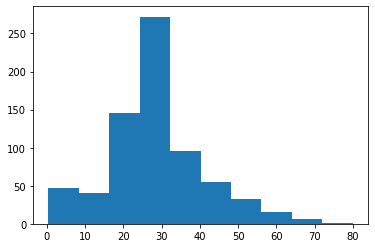

In [78]:
# -------------
# NORMALIZACIÓN
# -------------

# Comprobemos la distribución de las variables numéricas ('Age', 'Fare') con histogramas

plt.hist(data_train.loc[:, 'Age'])

(array([585.,  86.,  23.,   2.,   8.,   4.,   0.,   0.,   0.,   3.]),
 array([  0.     ,  51.23292, 102.46584, 153.69876, 204.93168, 256.1646 ,
        307.39752, 358.63044, 409.86336, 461.09628, 512.3292 ]),
 <a list of 10 Patch objects>)

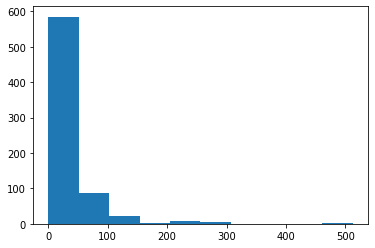

In [79]:
plt.hist(data_train.loc[:, 'Fare'])

In [80]:
# Ninguno de los datos sigue una distribución normal: usaremos la normalización MinMax

min_max_scaler = preprocessing.MinMaxScaler()
min_max_scaler.fit(data_train.loc[:, ['Fare', 'Age']])

data_train.loc[:, ['Fare', 'Age']] = min_max_scaler.transform(data_train.loc[:, ['Fare', 'Age']])
data_test.loc[:, ['Fare', 'Age']] = min_max_scaler.transform(data_test.loc[:, ['Fare', 'Age']])

In [178]:
#CORRELACIÓN ENTRE LOS DATOS

corr = data_train.corr()
corr.style.background_gradient(cmap='coolwarm')

,Age,SibSp,Parch,Fare,Survived,Pclass_Lower,Pclass_Middle,Pclass_Upper,Sex
Age,1.000000,-0.226584,-0.157138,0.115619,-0.065670,-0.309188,0.028613,0.335747,0.090612
SibSp,-0.226584,1.000000,0.406658,0.139916,-0.036973,0.108672,-0.072513,-0.057192,-0.124648
Parch,-0.157138,0.406658,1.000000,0.197215,0.082697,0.034485,-0.015159,-0.025793,-0.239960
Fare,0.115619,0.139916,0.197215,1.000000,0.240046,-0.397037,-0.123214,0.586896,-0.153459
Survived,-0.065670,-0.036973,0.082697,0.240046,1.000000,-0.314653,0.083327,0.288898,-0.535448
Pclass_Lower,-0.309188,0.108672,0.034485,-0.397037,-0.314653,1.000000,-0.581227,-0.610055,0.129630
Pclass_Middle,0.028613,-0.072513,-0.015159,-0.123214,0.083327,-0.581227,1.000000,-0.290194,-0.068129
Pclass_Upper,0.335747,-0.057192,-0.025793,0.586896,0.288898,-0.610055,-0.290194,1.000000,-0.086107
Sex,0.090612,-0.124648,-0.239960,-0.153459,-0.535448,0.129630,-0.068129,-0.086107,1.000000


In [81]:
# -------------------
# SEPARACIÓN EN X E Y
# -------------------

#Separamos los datos en X e Y

X_train = data_train.drop(['Survived'], axis=1)
y_train = data_train.loc[:, 'Survived']

X_test = data_test.drop(['Survived'], axis=1)
y_test = data_test.loc[:, 'Survived']

In [82]:
# ------------------------------------
# SEPARACIÓN DEL TRAIN EN TRAIN Y TEST
# ------------------------------------

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size= 0.25, shuffle=True)

#Red neuronal

In [168]:
# Algunos hiper-parámetros
lr = .01
batch_size = 50
n_epochs = 50
optimizer = tf.keras.optimizers.Adam(learning_rate=lr)

# Crear modelo
model = tf.keras.models.Sequential()
model.add(Dense(2, activation='relu', input_shape=(X_train.shape[1],)))
#model.add(Dense(2, activation='relu'))
model.add(Dense(1, activation='sigmoid'))


# Visualizar arquitectura y dimensiones
model.summary()

# Compilamos el modelo: ¿Qué función de coste hay que utilizar?
model.compile(loss='binary_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy', 'AUC'])

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_28 (Dense)             (None, 2)                 18        
_________________________________________________________________
dense_29 (Dense)             (None, 1)                 3         
Total params: 21
Trainable params: 21
Non-trainable params: 0
_________________________________________________________________


In [169]:
# Fitteamos el modelo

history = model.fit(X_train, y_train, batch_size=batch_size, epochs=n_epochs, shuffle=True, validation_data=(X_val, y_val))

Epoch 1/50
11/11 [==============================] - 0s 25ms/step - loss: 0.9958 - accuracy: 0.3527 - auc: 0.3516 - val_loss: 0.8262 - val_accuracy: 0.3820 - val_auc: 0.3244
Epoch 2/50
11/11 [==============================] - 0s 5ms/step - loss: 0.7737 - accuracy: 0.4334 - auc: 0.3793 - val_loss: 0.7110 - val_accuracy: 0.6067 - val_auc: 0.3654
Epoch 3/50
11/11 [==============================] - 0s 3ms/step - loss: 0.6981 - accuracy: 0.5797 - auc: 0.4916 - val_loss: 0.6768 - val_accuracy: 0.6067 - val_auc: 0.4732
Epoch 4/50
11/11 [==============================] - 0s 3ms/step - loss: 0.6752 - accuracy: 0.5797 - auc: 0.5664 - val_loss: 0.6534 - val_accuracy: 0.6124 - val_auc: 0.5177
Epoch 5/50
11/11 [==============================] - 0s 3ms/step - loss: 0.6525 - accuracy: 0.5966 - auc: 0.6127 - val_loss: 0.6357 - val_accuracy: 0.6517 - val_auc: 0.5721
Epoch 6/50
11/11 [==============================] - 0s 3ms/step - loss: 0.6377 - accuracy: 0.6698 - auc: 0.6411 - val_loss: 0.6267 - val_ac

In [170]:
results = pd.DataFrame(history.history)

from sklearn.metrics import roc_curve, auc
y_pred_keras = model.predict(X_test).ravel()
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test, y_pred_keras)

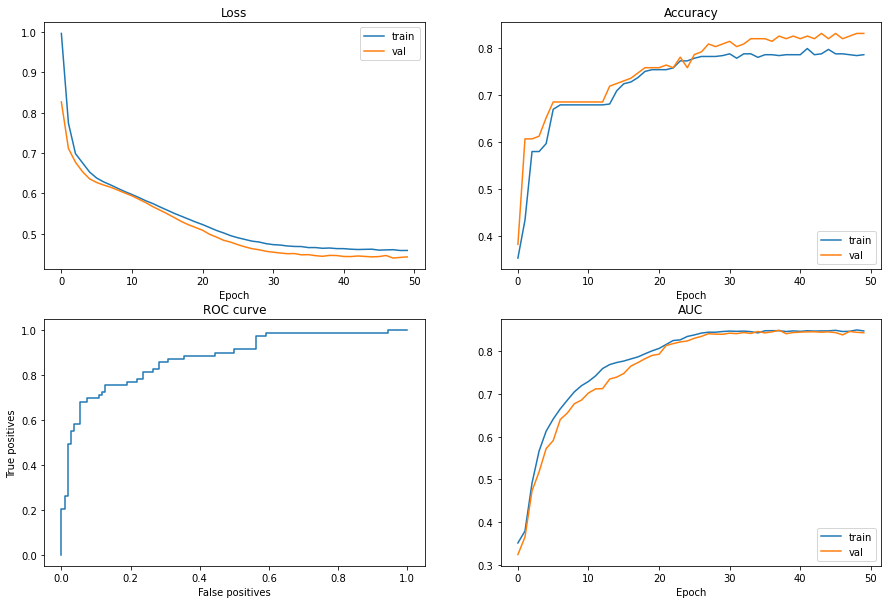

In [171]:
fig, ax = plt.subplots(2, 2)
fig.set_size_inches(15,10)

ax[0,0].plot(np.arange(0, results.shape[0]), results.loss, label='train')
ax[0,0].plot(np.arange(0, results.shape[0]), results.val_loss, label='val')
ax[0,0].set_xlabel('Epoch')
ax[0,0].title.set_text('Loss')
ax[0,0].legend(loc="upper right")

ax[0,1].plot(np.arange(0, results.shape[0]), results.accuracy, label='train')
ax[0,1].plot(np.arange(0, results.shape[0]), results.val_accuracy, label='val')
ax[0,1].set_xlabel('Epoch')
ax[0,1].title.set_text('Accuracy')
ax[0,1].legend(loc="lower right")

ax[1,0].plot(fpr_keras, tpr_keras)
ax[1,0].set_xlabel('False positives')
ax[1,0].set_ylabel('True positives')
ax[1,0].title.set_text('ROC curve')

ax[1,1].plot(np.arange(0, results.shape[0]), results.auc, label='train')
ax[1,1].plot(np.arange(0, results.shape[0]), results.val_auc, label='val')
ax[1,1].set_xlabel('Epoch')
ax[1,1].title.set_text('AUC')
ax[1,1].legend(loc="lower right")


In [172]:
model.evaluate(X_test, y_test)

6/6 [==============================] - 0s 2ms/step - loss: 0.4337 - accuracy: 0.8268 - auc: 0.8760


[0.4336807131767273, 0.826815664768219, 0.8760210871696472]

In [185]:
confusion_matrix(y_test, np.round(model.predict(X_test)))

array([[96, 14],
       [17, 52]])